El dataset corresponde a datos de pasajeros del titanic https://www.kaggle.com/c/titanic relacionado con la competición de kaggle para familiarizarse con el ML. Principalmente la respuesta es descubrir o predecir que influencio a la supervivencia de los pasajeros. Como no vamos a realizar ningún tipo de entrenamiento de ML solo se ha utilizado el test.csv. Compuesto por 12 columnas y 891 filas.



In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error

# Integración

In [44]:
titanic_df = pd.read_csv('../data/train.csv')
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [45]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Selección

Puede resultar interesante saber el titulo que posee un pasajero ya que podría haber una correlación con la supervivencia o con otros atributos como el coste del billete o los camarotes que poseían. Para obtener esta información hay que trabajar con el campo Name que posee el titulo con nombre y apellido del pasajero y realizar ciertas transformaciones para quedarnos unicamente con su titulo creando una nueva columna Title.

In [46]:
name = titanic_df["Name"].str.split(".", n = 1, expand = True )
title = name[0].str.split(",", n = 1, expand = True)[1]
titanic_df["Title"] = title.apply(lambda x: x.strip()).astype(str)


Otra posible transformación es crear una nueva columna con el numero de parientes que también viajan en el barco. Esto se logra sumando los campos SibSp (hermanos o cónyuges) y Parch (padres o hijos)

In [47]:
titanic_df["NFamily"] = titanic_df["SibSp"] + titanic_df["Parch"]

Podemos descubrir cuantos camarotes poseía un pasajero contando el numero de códigos de camarote del campo Cabin

In [48]:
def splitAndCount(cabin):
    return len(cabin.split(" "))

In [49]:
titanic_df["Cabin"] = titanic_df["Cabin"].astype(str)
cabins = titanic_df["Cabin"].apply(splitAndCount)
titanic_df["NCabin"] = cabins

Se realiza una conversión binaria en el campo Sex 0 para mujer y 1 para hombre. Y una particion en varias columnas los atributos Embarked y Title. De forma que las columnas donde exista un 1 cuyo titulo concuerde con el Title o el Embarked son las filas que poseían anteriormente dicho atributo. O en su defecto si todas las columnas son 0 significara que son del elemento faltante ya que por ejemplo para un atributo con 3 valores como Embarked solo se necesitan dos columnas para representarlo.

In [50]:
cat_dummies = pd.get_dummies(titanic_df[["Embarked","Title"]], drop_first=True)
titanic_df = pd.concat([titanic_df, cat_dummies], axis=1)
titanic_df["Sex"] = titanic_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)


Se eliminan las columnas PassengerId, Name, Ticket, Cabin, SibSp, Parch, Embarked y Title ya que con las transformaciones anteriores se puede cubrir la información que proporcionan estas columnas.

In [38]:
del titanic_df["PassengerId"]
del titanic_df["Name"]
del titanic_df["Ticket"]
del titanic_df["Cabin"]
del titanic_df["SibSp"]
del titanic_df["Parch"]
del titanic_df["Embarked"]
del titanic_df["Title"]
titanic_df

,Survived,Pclass,Sex,Age,Fare,NFamily,NCabin,Embarked_Q,Embarked_S,Title_Col,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
0,0,3,1,22.0,7.2500,1,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,1,1,0,38.0,71.2833,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,3,0,26.0,7.9250,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,1,1,0,35.0,53.1000,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,3,1,35.0,8.0500,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,13.0000,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
887,1,1,0,19.0,30.0000,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
888,0,3,0,NaN,23.4500,3,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
889,1,1,1,26.0,30.0000,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Conversión

### Normalización

In [10]:
scaler = MinMaxScaler()
titanic_normalized_df = pd.DataFrame(scaler.fit_transform(titanic_df), columns = titanic_df.columns)
titanic_normalized_df

,Survived,Pclass,Sex,Age,Fare,NFamily,NCabin,Embarked_Q,Embarked_S,Title_Col,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
0,0.0,1.0,1.0,0.271174,0.014151,0.1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.472229,0.139136,0.1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.321438,0.015469,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.434531,0.103644,0.1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.434531,0.015713,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,0.5,1.0,0.334004,0.025374,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
887,1.0,0.0,0.0,0.233476,0.058556,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,0.0,1.0,0.0,NaN,0.045771,0.3,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
889,1.0,0.0,1.0,0.321438,0.058556,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Datos perdidos

In [11]:
titanic_normalized_df.isnull().sum()

Survived                0
Pclass                  0
Sex                     0
Age                   177
Fare                    0
NFamily                 0
NCabin                  0
Embarked_Q              0
Embarked_S              0
Title_Col               0
Title_Don               0
Title_Dr                0
Title_Jonkheer          0
Title_Lady              0
Title_Major             0
Title_Master            0
Title_Miss              0
Title_Mlle              0
Title_Mme               0
Title_Mr                0
Title_Mrs               0
Title_Ms                0
Title_Rev               0
Title_Sir               0
Title_the Countess      0
dtype: int64

Se comprueba que existen 177 filas que no poseen el campo edad. Para tratar estos datos faltantes haremos uso del algoritmo KNN. Pero previamente se normalizan los datos con la función MinMaxScaler() que normaliza los datos a un rango de 0 y 1. Esta normalización es necesaria para que el algoritmo KNN tenga mayor precisión al calcular las distancias.

In [12]:
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(titanic_normalized_df)
titanic_normalized_df = pd.DataFrame(imputed, columns=titanic_normalized_df.columns)

titanic_normalized_df.isnull().sum()

Survived              0
Pclass                0
Sex                   0
Age                   0
Fare                  0
NFamily               0
NCabin                0
Embarked_Q            0
Embarked_S            0
Title_Col             0
Title_Don             0
Title_Dr              0
Title_Jonkheer        0
Title_Lady            0
Title_Major           0
Title_Master          0
Title_Miss            0
Title_Mlle            0
Title_Mme             0
Title_Mr              0
Title_Mrs             0
Title_Ms              0
Title_Rev             0
Title_Sir             0
Title_the Countess    0
dtype: int64

# Valores extremos

In [53]:
def rev_min_max_func(scaled_val,column):
    max_val = max(titanic_df[column])
    min_val = min(titanic_df[column])
    og_val = (scaled_val*(max_val - min_val)) + min_val
    return og_val


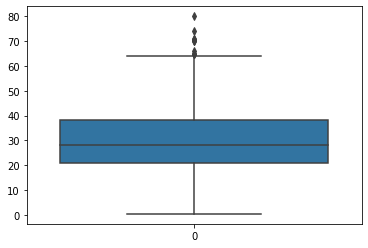

In [54]:
age = titanic_normalized_df['Age'].apply(lambda x: rev_min_max_func(x,"Age"))
sns.boxplot(data = age)

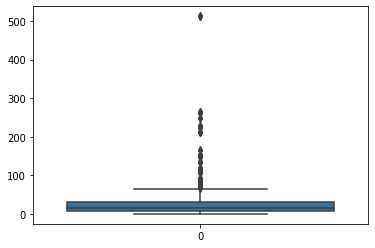

In [55]:
fare = titanic_normalized_df['Fare'].apply(lambda x: rev_min_max_func(x,"Fare"))
sns.boxplot(data = fare)

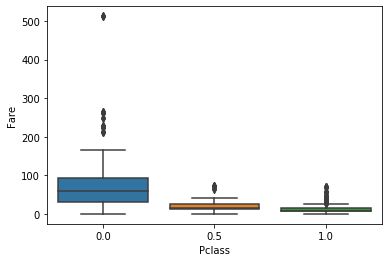

In [57]:
sns.boxplot(data = titanic_normalized_df, x = "Pclass", y = fare)

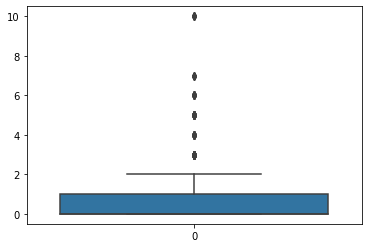

In [60]:
family = titanic_normalized_df['NFamily'].apply(lambda x: rev_min_max_func(x,"NFamily"))
sns.boxplot(data = family)

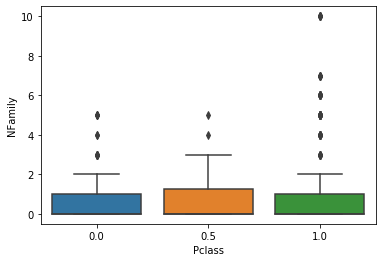

In [62]:
sns.boxplot(data = titanic_normalized_df, x = "Pclass", y = family)

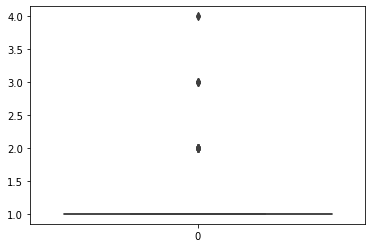

In [61]:
nCabin = titanic_normalized_df['NCabin'].apply(lambda x: rev_min_max_func(x,"NCabin"))
sns.boxplot(data = nCabin)

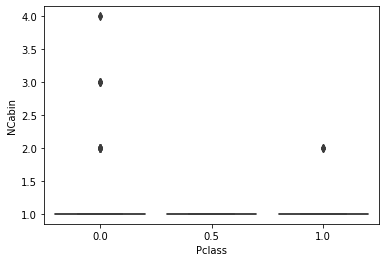

In [63]:
sns.boxplot(data = titanic_normalized_df, x = "Pclass", y = nCabin)

## Comprobacion de la normalidad

Age
----------------------------------------------
Shapiro-Wilk: 0.983,p-valor= 0.000
Kolmogorov-Smirnov: 0.500,p-valor= 0.000


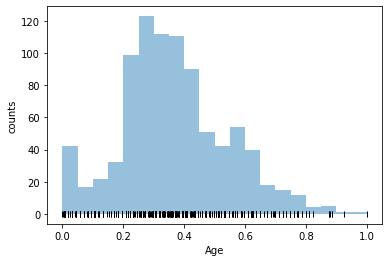

Fare
----------------------------------------------
Shapiro-Wilk: 0.522,p-valor= 0.000
Kolmogorov-Smirnov: 0.500,p-valor= 0.000


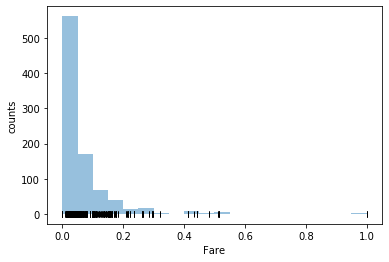

NFamily
----------------------------------------------
Shapiro-Wilk: 0.615,p-valor= 0.000
Kolmogorov-Smirnov: 0.500,p-valor= 0.000


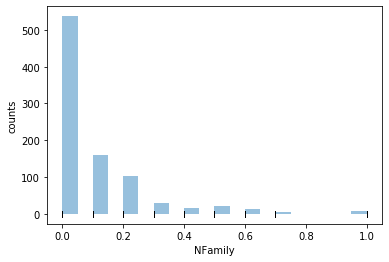

NCabin
----------------------------------------------
Shapiro-Wilk: 0.138,p-valor= 0.000
Kolmogorov-Smirnov: 0.500,p-valor= 0.000


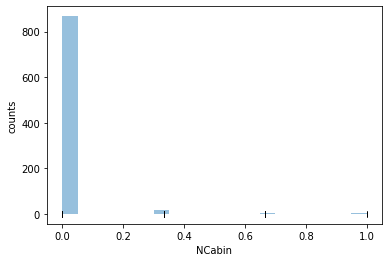

In [18]:
column_cuant = ["Age","Fare","NFamily","NCabin"]
for column in column_cuant:
    shapiro_test = stats.shapiro(titanic_normalized_df[column])
    kolmo_test = stats.kstest(titanic_normalized_df[column],'norm')
    print(column)
    print('----------------------------------------------')
    print('Shapiro-Wilk: %.3f,p-valor= %.3f' % shapiro_test)
    print('Kolmogorov-Smirnov: %.3f,p-valor= %.3f' % kolmo_test)
    plt.hist(x=titanic_normalized_df[column], bins=20, color="#3182bd", alpha=0.5)
    plt.plot(titanic_normalized_df[column], np.full_like(titanic_normalized_df[column], -0.01), '|k', markeredgewidth=1)
    plt.xlabel(column)
    plt.ylabel('counts')
    plt.show()

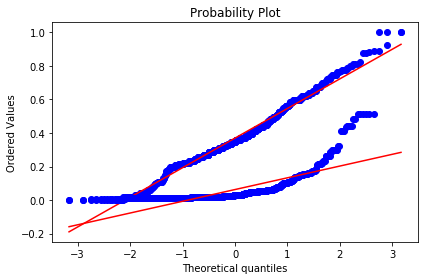

In [19]:

stats.probplot(titanic_normalized_df["Age"],plot=plt)
stats.probplot(titanic_normalized_df["Fare"],plot=plt)
plt.tight_layout();

<Figure size 432x288 with 0 Axes>

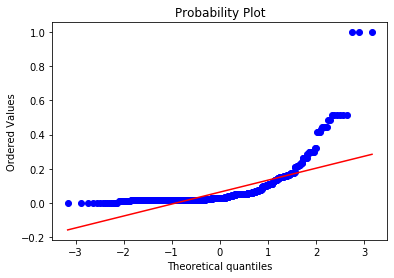

<Figure size 432x288 with 0 Axes>

In [20]:
stats.probplot(titanic_normalized_df["Fare"],plot=plt)
plt.figure()

# Correlación

In [21]:
titanic_normalized_df.corr()

,Survived,Pclass,Sex,Age,Fare,NFamily,NCabin,Embarked_Q,Embarked_S,Title_Col,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
Survived,1.000000,-0.338481,-0.543351,-0.098612,0.257307,0.016639,0.072724,0.003650,-0.155660,0.011329,...,0.085221,0.327093,0.060095,0.042470,-0.549199,0.339040,0.042470,-0.064988,0.042470,0.042470
Pclass,-0.338481,1.000000,0.131900,-0.384010,-0.549500,0.065997,-0.194303,0.221009,0.081720,-0.074282,...,0.082081,-0.000576,-0.074282,-0.052496,0.142698,-0.149209,-0.012381,-0.030413,-0.052496,-0.052496
Sex,-0.543351,0.131900,1.000000,0.150848,-0.182333,-0.200988,-0.046732,-0.074115,0.125722,0.034990,...,0.159934,-0.686808,-0.064296,-0.045439,0.867334,-0.547600,-0.045439,0.060741,0.024728,-0.045439
Age,-0.098612,-0.384010,0.150848,1.000000,0.090441,-0.312027,-0.039444,0.023183,-0.045920,0.094488,...,-0.386547,-0.323876,-0.019594,-0.013847,0.257852,0.163652,-0.004362,0.077626,0.045434,0.007494
Fare,0.257307,-0.549500,-0.182333,0.090441,1.000000,0.217138,0.489373,-0.117216,-0.166603,-0.001126,...,0.010908,0.118271,0.025974,0.025037,-0.183766,0.105203,-0.012961,-0.023031,0.016687,0.036645
NFamily,0.016639,0.065997,-0.200988,-0.312027,0.217138,1.000000,0.171728,-0.058592,0.079977,-0.026608,...,0.372472,0.112838,-0.026608,-0.018804,-0.338014,0.156168,-0.018804,-0.029170,0.001983,-0.018804
NCabin,0.072724,-0.194303,-0.046732,-0.039444,0.489373,0.171728,1.000000,-0.046523,-0.045468,-0.007175,...,0.010176,0.066818,-0.007175,-0.005070,-0.042626,-0.009863,-0.005070,-0.012455,-0.005070,-0.005070
Embarked_Q,0.003650,0.221009,-0.074115,0.023183,-0.117216,-0.058592,-0.046523,1.000000,-0.496624,-0.014588,...,0.010478,0.171117,-0.014588,-0.010310,-0.078338,-0.089739,-0.010310,0.023515,-0.010310,-0.010310
Embarked_S,-0.155660,0.081720,0.125722,-0.045920,-0.166603,0.079977,-0.045468,-0.496624,1.000000,-0.023607,...,0.025291,-0.134000,-0.076588,-0.054125,0.118482,-0.002512,0.020759,0.020335,-0.054125,0.020759
Title_Col,0.011329,-0.074282,0.034990,0.094488,-0.001126,-0.026608,-0.007175,-0.014588,-0.023607,1.000000,...,-0.010283,-0.024031,-0.002250,-0.001590,-0.055767,-0.019160,-0.001590,-0.003905,-0.001590,-0.001590


In [22]:
for column in titanic_normalized_df:
    r, p = stats.spearmanr(titanic_normalized_df['Fare'], titanic_normalized_df[column])
    print(f"Fare/{column} - Correlación Spearman: r={r}, p-value={p}")

Fare/Survived - Correlación Spearman: r=0.32373613944480834, p-value=3.471227970207005e-23
Fare/Pclass - Correlación Spearman: r=-0.6880316726256098, p-value=6.194553731421917e-126
Fare/Sex - Correlación Spearman: r=-0.25959349893940864, p-value=3.45543432477396e-15
Fare/Age - Correlación Spearman: r=0.11140435297898435, p-value=0.0008650855552112347
Fare/Fare - Correlación Spearman: r=1.0, p-value=0.0
Fare/NFamily - Correlación Spearman: r=0.5289073328138333, p-value=2.269544192726839e-65
Fare/NCabin - Correlación Spearman: r=0.17734338862829252, p-value=9.90309858467511e-08
Fare/Embarked_Q - Correlación Spearman: r=-0.23214912466984722, p-value=2.284690071580912e-12
Fare/Embarked_S - Correlación Spearman: r=-0.03985478971145377, p-value=0.23465514744811095
Fare/Title_Col - Correlación Spearman: r=0.03859612912007336, p-value=0.24977690554542
Fare/Title_Don - Correlación Spearman: r=0.023593791551925637, p-value=0.4818220624918311
Fare/Title_Dr - Correlación Spearman: r=0.063697653931

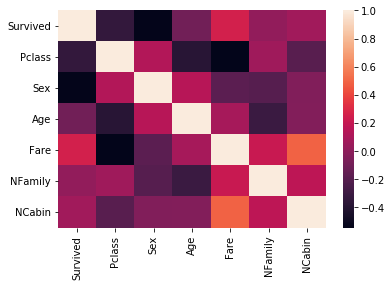

In [23]:
data = titanic_normalized_df[["Survived","Pclass","Sex","Age","Fare","NFamily","NCabin"]]
sns.heatmap(data.corr())

# Contraste de hipotesis

¿Inflye en la supevivencia de las mujeres la edad?
 Mann-Whitney 

Shapiro-Wilk: 0.977,p-valor= 0.001
Shapiro-Wilk: 0.969,p-valor= 0.045
MannwhitneyuResult(statistic=7730.0, pvalue=0.007662709137217837)


Text(0, 0.5, 'Age')

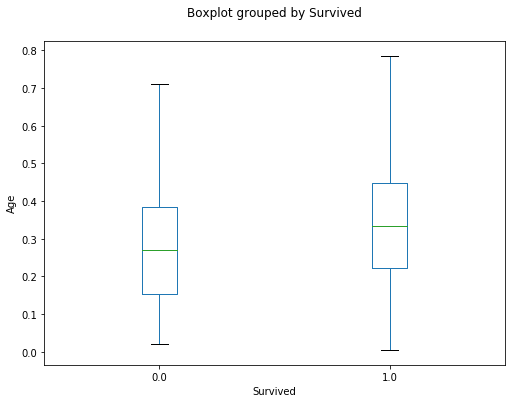

In [25]:
women_df = titanic_normalized_df.loc[(titanic_normalized_df["Sex"] == 0)]

women_survived_df = women_df[women_df["Survived"] == 1]
women_no_survived_df = women_df[women_df["Survived"] == 0]
shapiro_test = stats.shapiro(women_survived_df["Age"])
print('Shapiro-Wilk: %.3f,p-valor= %.3f' % shapiro_test)
shapiro_test = stats.shapiro(women_no_survived_df["Age"])
print('Shapiro-Wilk: %.3f,p-valor= %.3f' % shapiro_test)
mw = stats.mannwhitneyu(women_survived_df["Age"], women_no_survived_df["Age"])
print(mw)
axarr = women_df.boxplot(column='Age', by="Survived",
                   figsize=(8, 6), grid=False)
axarr.set_title('')
axarr.set_ylabel('Age')


In [26]:
contigency = pd.crosstab(titanic_normalized_df['Sex'], titanic_normalized_df['Survived']) 
chi2 = stats.chi2_contingency(contigency)
print('X-squared=%.4f, p-value=%.4f, df=%i expected_frep=%s'%chi2)

X-squared=260.7170, p-value=0.0000, df=1 expected_frep=[[193.47474747 120.52525253]
 [355.52525253 221.47474747]]


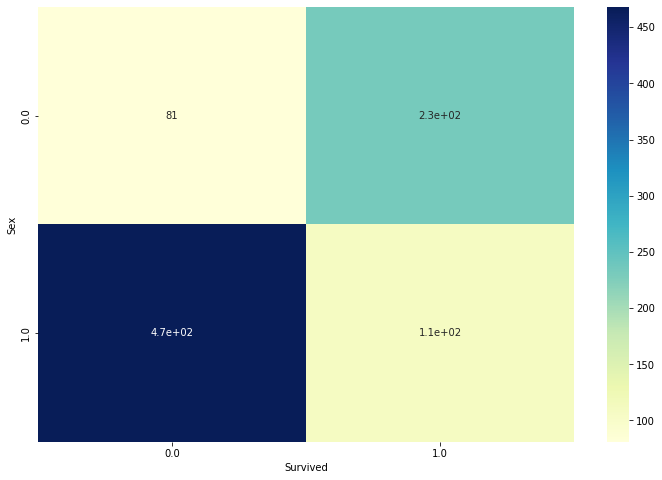

In [27]:
plt.figure(figsize=(12,8)) 
sns.heatmap(contigency, annot=True, cmap="YlGnBu")

# Regresion lineal

In [28]:
x = np.array(titanic_normalized_df["Fare"])
y = titanic_normalized_df["NCabin"].values
regresion_lineal = LinearRegression() 
regresion_lineal.fit(x.reshape(-1, 1), y) 
print('w = ' + str(regresion_lineal.coef_) + ', b = ' + str(regresion_lineal.intercept_))


w = [0.42449735], b = -0.013963445407372774


In [29]:
prediccion_entrenamiento = regresion_lineal.predict(x.reshape(-1,1))
mse = mean_squared_error(y_true = y, y_pred = prediccion_entrenamiento)

rmse = np.sqrt(mse)
print('Error Cuadrático Medio (MSE) = ' + str(mse))
print('Raíz del Error Cuadrático Medio (RMSE) = ' + str(rmse))


Error Cuadrático Medio (MSE) = 0.005377619551103466
Raíz del Error Cuadrático Medio (RMSE) = 0.07333225450716394


<Figure size 432x288 with 0 Axes>

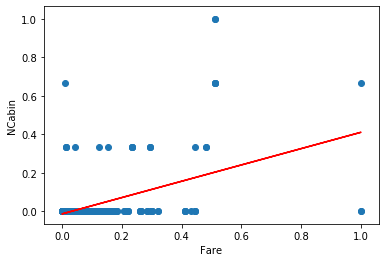

<Figure size 432x288 with 0 Axes>

In [30]:
def calcular_modelo(w,b,x):
    '''Retorna el valor w*x+b correspondiente al modelo lineal'''
    return w*x+b
w = regresion_lineal.coef_
b = regresion_lineal.intercept_
y_regr = calcular_modelo(w,b,x)
plt.scatter(titanic_normalized_df["Fare"],titanic_normalized_df["NCabin"])
plt.plot(x,y_regr,'r')
plt.xlabel("Fare")
plt.ylabel("NCabin")

plt.figure()